In [4]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

from lightgbm.sklearn import LGBMRanker

from typing import List

In [5]:
data = pd.read_parquet("../data/working/transactions_train.parquet")
data["t_dat"] = pd.to_datetime(data["t_dat"])

In [6]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [7]:
data.t_dat.max()

Timestamp('2020-09-22 00:00:00')

## Split data

In [59]:
def print_data_days(data):
    start_date = data.t_dat.iloc[0]
    end_date = data.t_dat.iloc[-1]
    diff_days = (end_date - start_date).days + 1
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    log = f"start_date={start_date} end_date={end_date} diff={diff_days}days"
    print(log)

def split_target(df: pd.DataFrame):
    max_t_dat = df["t_dat"].max()
    label_end_t_dat = max_t_dat - timedelta(days=7)

    X, y = df.query("t_dat<@label_end_t_dat"), df.query("t_dat>=@label_end_t_dat")
    return X, y
    
def split_data(data: pd.DataFrame, test_base_date: str, train_days: int = 7):
    label_days = 7
    
    test_base_date = datetime.strptime(test_base_date, '%Y-%m-%d')
    train_base_date = test_base_date - timedelta(days=label_days)
    
    test_end_date = test_base_date + timedelta(days=label_days)
    test_start_date = test_base_date - timedelta(days=train_days)
    
    train_end_date = train_base_date + timedelta(days=label_days)
    train_start_date = train_base_date - timedelta(days=train_days)
    
    test = data[(data["t_dat"] <= test_end_date) & (data["t_dat"] >= test_start_date)]
    train = data[(data["t_dat"] <= train_end_date) & (data["t_dat"] >= train_start_date)]
    
    X_train, y_train = split_target(train)
    X_test, y_test = split_target(test)
    
    print_data_days(X_train)
    print_data_days(y_train)
    
    print_data_days(X_test)
    print_data_days(y_test)
    
    y_train = y_train[["customer_id", "article_id"]]
    y_test = y_test[["customer_id", "article_id"]]
    
    return X_train, y_train, X_test, y_test

In [60]:
X_train, y_train, X_test, y_test = split_data(data, "2020-09-15", 28)

start_date=2020-08-26 end_date=2020-09-07 diff=13days
start_date=2020-09-08 end_date=2020-09-15 diff=8days
start_date=2020-08-26 end_date=2020-09-14 diff=20days
start_date=2020-09-15 end_date=2020-09-22 diff=8days


- ありもののデータを使う前提だと、y_xxxx だけで事足りそう
- 時系列の特徴量を使いたい場合は X_xxxx が必要

## Generate label data

In [10]:
active_article_id = pd.concat([X_train["article_id"], y_train["article_id"]], axis=0).value_counts().index.to_numpy()
popular_article_id = active_article_id[:500]

In [11]:
def gen_neg_data(c_id: str, c_data: pd.DataFrame):
    num_row = len(c_data)
    num_sample = num_row // 2

    c_data_article_id = c_data["article_id"].to_numpy().astype(np.int64)
    
    neg_random_article_id = np.random.choice(np.setdiff1d(active_article_id, c_data_article_id), 100)
    neg_popular_article_id = np.random.choice(np.setdiff1d(popular_article_id, c_data_article_id), num_sample)

    neg_article_id = np.union1d(neg_popular_article_id, neg_random_article_id)
    neg_data = np.array([np.repeat([c_id], repeats=len(neg_article_id)), neg_article_id])
    return neg_data


def gen_all_neg_data(data: pd.DataFrame):
    all_neg_data = Parallel(n_jobs=-1)(delayed(gen_neg_data)(c_id, gdf) for c_id, gdf in tqdm(data.groupby("customer_id")))
    neg_data = pd.DataFrame(np.concatenate(all_neg_data, axis=1).T, columns=["customer_id", "article_id"])
    neg_data = neg_data.assign(label=0)
    return neg_data


def gen_y_with_negative(y: pd.DataFrame):
    y = y[["customer_id", "article_id"]].copy()
    y = y.assign(label=1)
    
    y_neg = gen_all_neg_data(y)
    y_w_neg = pd.concat([y, y_neg], axis=0).reset_index(drop=True)
    y_w_neg["article_id"] = y_w_neg["article_id"].astype(np.int64)
    return y_w_neg

In [12]:
y_train_w_neg = gen_y_with_negative(y_train)

  0%|          | 0/80765 [00:00<?, ?it/s]

In [13]:
y_test_w_neg = gen_y_with_negative(y_test)

  0%|          | 0/75481 [00:00<?, ?it/s]

## Join user and item features

In [14]:
user_features = pd.read_parquet("../data/user_features.parquet")
item_features = pd.read_parquet("../data/item_features.parquet")

user_features = user_features.reset_index()
item_features = item_features.reset_index()

In [15]:
user_features[['club_member_status', 'fashion_news_frequency']] = (
                   user_features[['club_member_status', 'fashion_news_frequency']]
                   .apply(lambda x: pd.factorize(x)[0])
).astype('int8')

In [16]:
data = (
    y_train_w_neg
    .merge(user_features, on='customer_id', how="left")
    .merge(item_features, on='article_id', how="left")
).reset_index(drop=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
query_list = data['customer_id'].value_counts()
data = data.set_index(['customer_id', 'article_id'])
query_list = query_list.sort_index()
data.sort_index(inplace=True)

In [17]:
data["label"].mean()

0.034400880852025

In [18]:
print(data.shape)
data.head(10)

(8478155, 84)


label  \
customer_id                                        article_id          
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad... 448515001       0   
                                                   494088022       0   
                                                   516712010       0   
                                                   589599010       0   
                                                   614622006       0   
                                                   620424060       0   
                                                   622964005       0   
                                                   635689002       0   
                                                   644797008       0   
                                                   663275003       0   

                                                               mean_transactions  \
customer_id                                        article_id                      
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad... 448515001            0.039154   
                                                   494088022            0.039154   
                                                   516712010            0.039154   
                                                   589599010            0.039154   
                                                   614622006            0.039154   
                                                   620424060            0.039154   
                                                   622964005            0.039154   
                                                   635689002            0.039154   
                                                   644797008            0.039154   
                                                   663275003            0.039154   

                                                               max_transactions  \
customer_id                                        article_id                     
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad... 448515001            0.06778   
                                                   494088022            0.06778   
                                                   516712010            0.06778   
                                                   589599010            0.06778   
                                                   614622006            0.06778   
                                                   620424060            0.06778   
                                                   622964005            0.06778   
                                                   635689002            0.06778   
                                                   644797008            0.06778   
                                                   663275003            0.06778   

                                                               min_transactions  \
customer_id                                        article_id                     
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad... 448515001           0.013542   
                                                   494088022           0.013542   
                                                   516712010           0.013542   
                                                   589599010           0.013542   
                                                   614622006           0.013542   
                                                   620424060           0.013542   
                                                   622964005           0.013542   
                                                   635689002           0.013542   
                                                   644797008           0.013542   
                                                   663275003           0.013542   

                                                               median_transactions  \
customer_id                                        article_id                        
000058a12d5b43e67d22566

In [19]:
test = (
    y_test_w_neg
    .merge(user_features, on='customer_id', how="left")
    .merge(item_features, on='article_id', how="left")
).reset_index(drop=True)
test_query_list = test['customer_id'].value_counts()
test = test.set_index(['customer_id', 'article_id'])
test_query_list = test_query_list.sort_index()
test.sort_index(inplace=True)

In [20]:
import lightgbm as lgb

label = data["label"]
inputs = data.drop("label", axis=1)

eval_label = test["label"]
eval_inputs = test.drop("label", axis=1)

model = lgb.LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="gbdt",
    learning_rate=0.3,
    n_estimators=500,
    random_state=42,
    max_depth=5,
    num_leaves=5**2,
    min_child_samples=100,
    force_col_wise=True,
    importance_type='gain',
    verbosity=-1,
)
model.fit(
    inputs,
    label,
    group=query_list,
    eval_set=[(inputs, label), (eval_inputs, eval_label)],
    eval_group=[query_list, test_query_list],
    eval_at=[12],
    eval_metric="map",
    callbacks=[lgb.log_evaluation(20), lgb.early_stopping(20)],
)

Training until validation scores don't improve for 20 rounds
[20]	training's map@12: 0.354413	training's ndcg@12: 0.472153	valid_1's map@12: 0.342287	valid_1's ndcg@12: 0.459163
[40]	training's map@12: 0.397094	training's ndcg@12: 0.514306	valid_1's map@12: 0.384347	valid_1's ndcg@12: 0.501186
[60]	training's map@12: 0.423943	training's ndcg@12: 0.540561	valid_1's map@12: 0.407936	valid_1's ndcg@12: 0.524671
[80]	training's map@12: 0.440315	training's ndcg@12: 0.556218	valid_1's map@12: 0.422533	valid_1's ndcg@12: 0.538759
[100]	training's map@12: 0.451063	training's ndcg@12: 0.56641	valid_1's map@12: 0.431808	valid_1's ndcg@12: 0.547574
[120]	training's map@12: 0.459799	training's ndcg@12: 0.574713	valid_1's map@12: 0.439278	valid_1's ndcg@12: 0.554698
[140]	training's map@12: 0.466919	training's ndcg@12: 0.581476	valid_1's map@12: 0.444152	valid_1's ndcg@12: 0.55948
[160]	training's map@12: 0.472588	training's ndcg@12: 0.586886	valid_1's map@12: 0.448866	valid_1's ndcg@12: 0.564123
[

LGBMRanker(force_col_wise=True, importance_type='gain', learning_rate=0.3,
           max_depth=5, metric='ndcg', min_child_samples=100, n_estimators=500,
           num_leaves=25, objective='lambdarank', random_state=42,
           verbosity=-1)

## Evaluation

In [21]:
def average_precision(target, predict, k=12):
    len_target = min(len(target), k)

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predict):
        if p in target and p not in predict[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len_target, k)


def mean_average_precision(targets, predicts, k=12):
    map_top_k = np.mean([average_precision(t, p) for t, p in zip(targets, predicts)])
    assert 0.0 <= map_top_k <= 1.0, "map_top_k must be 0.0 <= map_top_k <= 1.0"
    return map_top_k

In [22]:
# TODO: predict をバッチで行う、データが多すぎるので。

pred = model.predict(eval_inputs)
eval_pred = pd.DataFrame(index=eval_inputs.index, data=pred, columns=["score"])
eval_pred = eval_pred.reset_index()

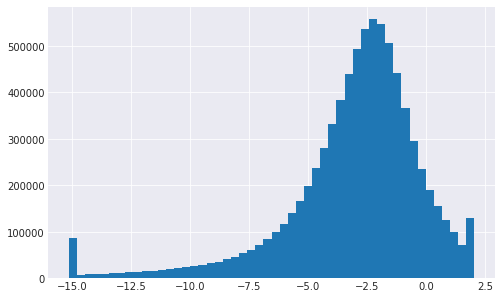

In [23]:
c_min, c_max = np.percentile(pred, [1, 99])

plt.figure(figsize=(8,5))
plt.hist(np.clip(pred, c_min, c_max), bins=50)
plt.show()

In [24]:
eval_pred.sort_values(['customer_id', 'score'], ascending=False, inplace = True)
eval_pred = (
    eval_pred
    .groupby('customer_id')[['article_id']]
    .aggregate(lambda x: x.tolist()[:12])
)

In [25]:
eval_pred['article_id'] = eval_pred['article_id'].apply(lambda x: ' '.join(['0'+str(k) for k in x]))

In [26]:
target = eval_label[eval_label==1].reset_index()[["customer_id", "article_id"]].copy()
target = target.groupby("customer_id")["article_id"].agg(list).to_frame()
target = target["article_id"].tolist()

In [27]:
pred = eval_pred["article_id"].str[1:]
pred = pred.str.split(" 0").tolist()
pred = [[int(_p) for _p in p] for p in pred]

mean_average_precision(target, pred)

0.44835220866814623

## Prediction

# TODO

- 提出用データで同様の処理を実施
- 再学習
- 予測
- 提出

In [345]:
data = pd.read_parquet("../data/working/transactions_train.parquet")
data["t_dat"] = pd.to_datetime(data["t_dat"])

label_end_t_dat = data["t_dat"].max() - timedelta(days=28)
data = data.query("t_dat>=@label_end_t_dat")

print_data_days(data)

start_date=2020-08-25 end_date=2020-09-22 diff=29days


In [346]:
active_article_id = data["article_id"].value_counts().index.to_numpy()
popular_article_id = active_article_id[:50]

In [347]:
sample_submission = pd.read_csv("../data/raw/sample_submission.csv")

In [348]:
sample_submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [349]:
%%time

# TODO: 人気かつ過去28日間で購入した商品にするとさらによさそう
size = len(popular_article_id)
c_id = sample_submission.customer_id.iloc[0]

CPU times: user 420 µs, sys: 8 µs, total: 428 µs
Wall time: 401 µs


In [350]:
%%time
c_feat = user_features.query("customer_id==@c_id").iloc[0, 1:].to_numpy()
c_feat = np.tile(c_feat, (size, 1))

i_feat = item_features.set_index("article_id").loc[popular_article_id].to_numpy()

feat = np.concatenate((c_feat, i_feat), axis=1)

CPU times: user 54.4 ms, sys: 83 µs, total: 54.5 ms
Wall time: 48.6 ms


In [351]:
%%time
pred = model.predict(feat)

CPU times: user 0 ns, sys: 2.45 ms, total: 2.45 ms
Wall time: 1.33 ms


In [352]:
%%time
pred_article = popular_article_id[np.argsort(pred)][::-1][:12]
pred_article = " ".join(["0"+str(p) for p in pred_article])

CPU times: user 138 µs, sys: 3 µs, total: 141 µs
Wall time: 96.3 µs


In [353]:
%%time
pred_article

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 5.25 µs


'0909370001 0924243001 0915529003 0896152002 0863595006 0915526001 0898694001 0918522001 0929165002 0893059004 0863583001 0850917001'

In [354]:
%%time
c_id

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


'00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'

# TODO

- u_feat, i_feat をジョイン
- batch で予測する

In [355]:
sub_c_ids = sample_submission["customer_id"].to_numpy()

In [359]:
i_feat = item_features.set_index("article_id").loc[popular_article_id].to_numpy()

def predict(c_id):
    a_ids = popular_article_id.reshape(-1, size)

    # TODO: user_feature に c_id が存在しない場合の仮データを入れる必要がある
    c_feat = user_features.query("customer_id==@c_id").iloc[0, 1:].to_numpy()
    c_feat = np.tile(c_feat, (size, 1))

    feat = np.concatenate((c_feat, i_feat), axis=1)
    
    pred = model.predict(feat)
    pred_ids = a_ids.ravel()[np.argsort(pred)][::-1][:12]
    pred_ids = " ".join(["0"+str(p) for p in pred_ids])
    
    return (row.customer_id, pred_ids)    

In [360]:
%%time
smpl_c_id = sub_c_ids[0]
predict(smpl_c_id)

CPU times: user 41.7 ms, sys: 27 µs, total: 41.7 ms
Wall time: 36.1 ms


('000b4826c39da9d7207a019e046e85115dd5ba928a5bf79cafa48833cfb1c579',
 '0909370001 0924243001 0915529003 0896152002 0863595006 0915526001 0898694001 0918522001 0929165002 0893059004 0863583001 0850917001')

In [361]:
submission = Parallel(n_jobs=-1)(delayed(predict)(c_id) for c_id in tqdm(sub_c_ids))

  0%|          | 0/1371980 [00:00<?, ?it/s]

IndexError: single positional indexer is out-of-bounds

In [ ]:
_, sub_data = split_data(train, "2020-09-22", 7)

In [ ]:
purchased_articles = most_purchase_articles_each_customer(sub_data)

In [ ]:
pop_result = most_popular_articles(sub_data)

In [ ]:
resultlt = purchased_articles[["customer_id"]].copy()

pred = pd.concat([purchased_articles["top_purchased_articles"], purchased_articles["top_purchased_articles"]], axis=1)
result["prediction"] = pred.apply(ensemble, weights=[1, 1], axis=1)

In [ ]:
result.head()

## Submission

In [ ]:
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [ ]:
sub = sub[["customer_id"]].copy().reset_index(drop=True)
sub = sub.merge(result, how="left", on="customer_id").fillna("")

sub["prediction"] = sub["prediction"] + pop_result
sub["prediction"] = sub["prediction"].str.strip()
sub["prediction"] = sub["prediction"].str[:131]

In [ ]:
sub.to_csv("../data/submit/00101.csv", index=False)
sub.head()